In [1]:
import os, sys, yaml, torch, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch
import torch.nn as nn
sys.path.append("../src")
sys.path.append("../configs")
from torch.utils.data import DataLoader
from utils import set_seed, visualize_actual_vs_predicted, save_model, get_scheduler, classification, load_model
from data_preparation import load_and_process_data, create_edge_index
from dataset import CustomDataset, PredictDataset
from model import GATFeatureExtractor, GATLSTMPredictor, weights_init
from train import train_model, gat_train, validate_model
from sklearn.model_selection import train_test_split

In [3]:
with open('../configs/config.yaml', 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# if torch.cuda.is_available():
#     device = torch.device("cuda:0")   # NVIDIA GPU
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")      # Apple Silicon GPU
# else:
#     device = torch.device("cpu")      # CPU

In [5]:
file_path = config['file_path']
column_name = config['devices']
input_dim = len(column_name)
window_size = config['window_size']
num_epochs = config['gat']['num_epochs']
batch_size = config['gat']['batch_size']

All columns: ['Aggregate Load', 'Hour', 'Unknown', 'WashingMachine', 'Dishwasher', 'Dryer', 'Television', 'Computer']


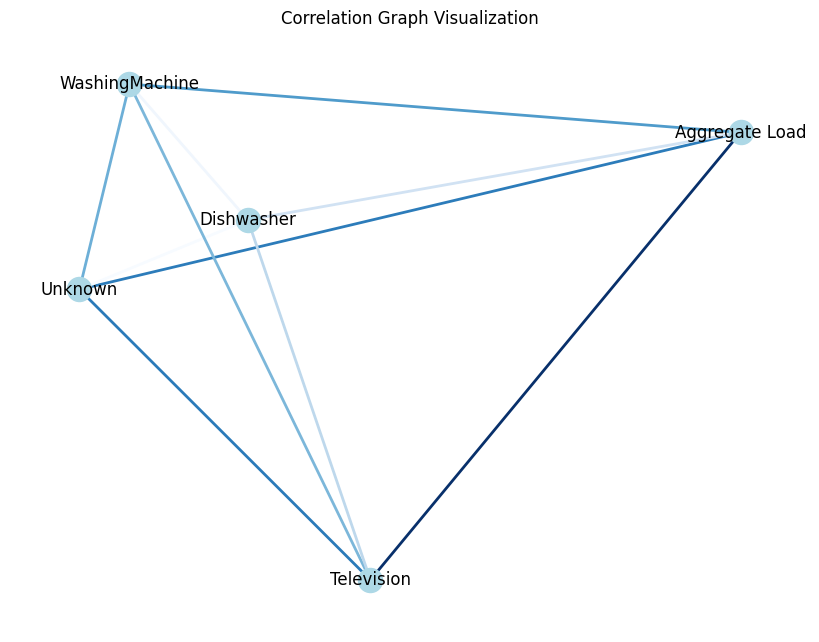

In [6]:
# Read data and build graph structure
data = load_and_process_data(file_path, column_name, window_size)
edge_index = create_edge_index(data)

In [7]:
train_data, test_data = train_test_split(data, test_size=0.2)

In [8]:
gat_feature_extractor = GATFeatureExtractor(num_features=input_dim+2, num_classes=input_dim+2).to(device)
gat_feature_extractor.apply(weights_init)

GATFeatureExtractor(
  (gat1): GATConv(8, 32, heads=8)
  (gat2): GATConv(256, 256, heads=1)
  (transformer_conv): TransformerConv(256, 8, heads=1)
  (residual_connect): Linear(in_features=8, out_features=8, bias=True)
  (input_projection): Linear(in_features=8, out_features=256, bias=True)
  (activation): Tanh()
)

In [9]:
# Choose and create GAT loss function from config
if config['gat']['loss_function']['type'] == 'MSELoss':
    criterion = nn.MSELoss()
elif config['gat']['loss_function']['type'] == 'L1Loss':
    criterion = nn.L1Loss()

In [10]:
# Choose and create GAT optimizer
optimizer_config = config['gat']['optimizer']
if optimizer_config['type'] == 'Adam':
    optimizer = torch.optim.Adam(gat_feature_extractor.parameters(), lr=optimizer_config['learning_rate'])
elif optimizer_config['type'] == 'SGD':
    optimizer = torch.optim.SGD(gat_feature_extractor.parameters(), lr=optimizer_config['learning_rate'])

In [11]:
# Create dataset for training the GAT model
train_dataset_feature_extractor = CustomDataset(train_data, devices=column_name, is_feature_extractor=True)
test_dataset_feature_extractor = CustomDataset(test_data, devices=column_name, is_feature_extractor=True)
train_loader_feature_extractor = DataLoader(train_dataset_feature_extractor, batch_size=batch_size, shuffle=True)
test_loader_feature_extractor = DataLoader(test_dataset_feature_extractor, batch_size=batch_size, shuffle=True)

In [12]:
# Train GAT
gat_train(gat_feature_extractor, train_loader_feature_extractor, test_loader_feature_extractor,
            criterion, optimizer, num_epochs, device, edge_index)

Epoch [1/20], Training Loss: 0.3249402215331793, Validation Loss: 0.2675475735394728
Epoch [2/20], Training Loss: 0.27212234384566547, Validation Loss: 0.2503051043502868
Epoch [3/20], Training Loss: 0.25038440150022506, Validation Loss: 0.24229284112770405
Epoch [4/20], Training Loss: 0.24147064884006977, Validation Loss: 0.2401443629540385
Epoch [5/20], Training Loss: 0.23728804111108184, Validation Loss: 0.23895710641666065
Epoch [6/20], Training Loss: 0.23574012686312198, Validation Loss: 0.24324670685307373
Epoch [7/20], Training Loss: 0.2345438099503517, Validation Loss: 0.2372619691822264
Epoch [8/20], Training Loss: 0.23295157439261674, Validation Loss: 0.24010855030445827
Epoch [9/20], Training Loss: 0.23207118490710854, Validation Loss: 0.23722107309315885
Epoch [10/20], Training Loss: 0.23163579221069813, Validation Loss: 0.23653683734555092
Epoch [11/20], Training Loss: 0.23143595154955984, Validation Loss: 0.23622370815821112
Epoch [12/20], Training Loss: 0.231174033947289

In [13]:
# Load the pretrained GAT model
pretrained_gat = GATFeatureExtractor(num_features=input_dim+2, num_classes=input_dim+2).to(device)
pretrained_gat.load_state_dict(torch.load('../models/gat_feature_extractor.pth'))
model = GATLSTMPredictor(num_features=2, num_classes=input_dim, gat_feature_extractor=pretrained_gat).to(device)
model.apply(weights_init)

GATLSTMPredictor(
  (gat_feature_extractor): GATFeatureExtractor(
    (gat1): GATConv(8, 32, heads=8)
    (gat2): GATConv(256, 256, heads=1)
    (transformer_conv): TransformerConv(256, 8, heads=1)
    (residual_connect): Linear(in_features=8, out_features=8, bias=True)
    (input_projection): Linear(in_features=8, out_features=256, bias=True)
    (activation): Tanh()
  )
  (feature_transform): Linear(in_features=2, out_features=8, bias=True)
  (lstm1): LSTM(8, 20, num_layers=2, batch_first=True, bidirectional=True)
  (lstm2): LSTM(40, 20, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=40, out_features=6, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [14]:
# Choose and create GAT-LSTM loss function from config
if config['gat_lstm']['loss_function']['type'] == 'MSELoss':
    criterion = nn.MSELoss()
elif config['gat_lstm']['loss_function']['type'] == 'L1Loss':
    criterion = nn.L1Loss()
optimizer_config = config['gat_lstm']['optimizer']
if optimizer_config['type'] == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=optimizer_config['learning_rate'])
elif optimizer_config['type'] == 'SGD':
    optimizer = torch.optim.SGD(model.parameters(), lr=optimizer_config['learning_rate'])
# Learning rate scheduler
scheduler_config = {
    'type': 'StepLR',
    'step_size': 30,
    'gamma': 0.1
}
scheduler = get_scheduler(optimizer, scheduler_config)

In [15]:
# Load GAT-LSTM data
num_epochs = config['gat_lstm']['num_epochs']
batch_size = config['gat_lstm']['batch_size']
train_dataset = CustomDataset(train_data, devices=column_name)
test_dataset = CustomDataset(test_data, devices=column_name, feature_scaler=train_dataset.get_feature_scaler(),
                                label_scaler=train_dataset.get_label_scaler())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

trained_model, all_aggregate, all_predictions, all_values = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, edge_index, train_dataset, scheduler)

save_model(trained_model, '../models/model.pth')

Epoch 1/25, Loss: 0.5257903764247894
Validation Loss: 0.39765772140688366
Epoch 2/25, Loss: 0.40629244938492776
Validation Loss: 0.3684657502268988
Epoch 3/25, Loss: 0.3985123721063137
Validation Loss: 0.36580014216994483
Epoch 4/25, Loss: 0.39295161256194117
Validation Loss: 0.3614400562549394
Epoch 5/25, Loss: 0.3738772966861725
Validation Loss: 0.336593900496761
Epoch 6/25, Loss: 0.35277133679389955
Validation Loss: 0.3229401610969078
Epoch 7/25, Loss: 0.33788381940871476
Validation Loss: 0.3046816483376518
Epoch 8/25, Loss: 0.32549028846621514
Validation Loss: 0.3098794324767022
Epoch 9/25, Loss: 0.32646699878573415
Validation Loss: 0.29134387233191067
Epoch 10/25, Loss: 0.3112100662887096
Validation Loss: 0.27695573156788234
Epoch 11/25, Loss: 0.3070976787954569
Validation Loss: 0.2752068019398148
Epoch 12/25, Loss: 0.295861480936408
Validation Loss: 0.2593181905233198
Epoch 13/25, Loss: 0.29591291220486166
Validation Loss: 0.2594290956973083
Epoch 14/25, Loss: 0.2778881472945213


### Training Data

Validation Loss: 0.24067856462299825


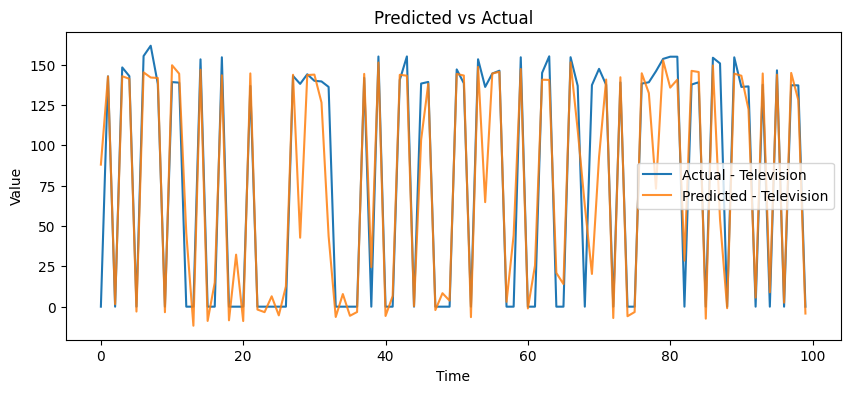

Television: MAE=15.4122, RMSE=28.2661, R2=0.8462


In [16]:
# Plot predicted vs actual on TRAIN set
_, all_aggregate_train, all_predictions_train, all_values_train = validate_model(model, train_loader, criterion, device, edge_index, train_dataset)
visualize_actual_vs_predicted(all_predictions_train, all_values_train, all_aggregate_train, column_name, devices=['Television'], start=100, end=200)

### Validation Data

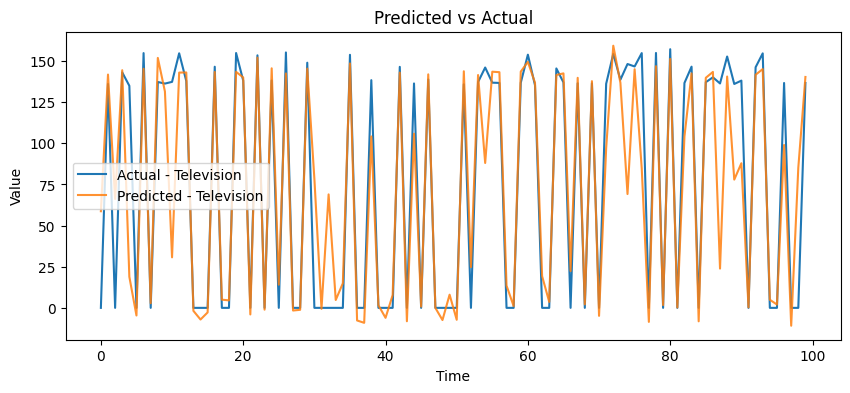

Television: MAE=16.6550, RMSE=30.7767, R2=0.8153


In [17]:
visualize_actual_vs_predicted(all_predictions, all_values, all_aggregate, column_name, devices=['Television'], start=100, end=200)

In [18]:
# Prediction data
predict_data = test_data

feature_scaler = train_dataset.get_feature_scaler()
predict_dataset = PredictDataset(predict_data, feature_scaler)

# Load the pretrained GAT feature extractor model
gat_feature_extractor = GATFeatureExtractor(num_features=input_dim+2, num_classes=input_dim+2)
gat_feature_extractor = load_model(gat_feature_extractor, '../models/gat_feature_extractor.pth', device)

# Load the pretrained GAT-LSTM model
gat_lstm_model = GATLSTMPredictor(num_features=2, num_classes=input_dim, gat_feature_extractor=gat_feature_extractor)
gat_lstm_model = load_model(gat_lstm_model, '../models/model.pth', device)

# Run inference
gat_lstm_model.eval()
with torch.no_grad():
    # Ensure inputs and graph are on the same device as the model
    features_dev = predict_dataset.features.to(device)
    edge_index_dev = edge_index.to(device) if hasattr(edge_index, 'to') else edge_index
    predictions = gat_lstm_model(features_dev, edge_index_dev)
    # Move to CPU before using sklearn scalers
    predictions = predictions.detach().cpu().numpy()
    predictions = train_dataset.get_label_scaler().inverse_transform(predictions)

In [19]:
# Save prediction results
# predict_data = predict_data.reset_index(drop=True)
# df = pd.DataFrame(predictions, columns=column_name)
# result = pd.concat([predict_data, df], axis=1)
df_pred = pd.DataFrame(predictions, columns=[f"{c}_pred" for c in column_name])
df_pred_aligned = df_pred.copy()
df_pred_aligned.index = predict_data.index 

result = pd.concat([predict_data, df_pred_aligned], axis=1)

In [20]:
# Classify device status
status, metrics = classification(result, column_name, return_metrics=True)
result = pd.concat([result, status], axis=1)
metrics

{'Unknown': {'accuracy': 0.9645,
  'precision': 0.8625,
  'recall': 0.9108910891089109,
  'f1': 0.8860353130016051,
  'n': 2000},
 'WashingMachine': {'accuracy': 0.9795,
  'precision': 0.8,
  'recall': 0.45161290322580644,
  'f1': 0.5773195876288659,
  'n': 2000},
 'Dishwasher': {'accuracy': 0.99,
  'precision': 0.7906976744186046,
  'recall': 0.7555555555555555,
  'f1': 0.7727272727272727,
  'n': 2000},
 'Dryer': {'accuracy': 1.0,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'n': 2000},
 'Television': {'accuracy': 0.9335,
  'precision': 0.9556213017751479,
  'recall': 0.9167455061494797,
  'f1': 0.9357798165137615,
  'n': 2000},
 'Computer': {'accuracy': 1.0,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'n': 2000}}

In [21]:
result.to_csv('prediction_results.csv', index=False)